# Network Modeling with SEIRS+ Notebook 

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from seirsplus.models import *
from network_utils import *
from stats_utils import *
from intervention_utils import *

### Parameters

Here, we define the parameters taken from the Tucker model. These can be customized further and then the rest of the cells can be run. We are dividing the tents zones into 3 big blocks for grid/measuring proximity purposes

In [2]:
n_pop = 18700

# Grid info for isoboxes
dims_isoboxes = (29, 28)  # 812

# Grid info for tents
dims_block1 = (20, 67)  # 1340
dims_block2 = (53, 15)  # 795
dims_block3 = (19, 28)  # 532

# Isoboxes
pop_isoboxes = 8100
pop_per_isobox = 10
n_isoboxes = dims_isoboxes[0]*dims_isoboxes[1]

# Tents
n_tents = 2650
pop_tents = 10600
pop_per_tent = 4

# Others 
n_bathrooms = 144
n_ethnic_groups = 8

# We define neighboring structures within a range of 2 in the structure grid
proximity = 2

# Define the maximum population per structures (tents and isoboxes) drawn from a poisson distribution
max_pop_per_struct = list(poisson.rvs(mu=pop_per_isobox, size=n_isoboxes))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=pop_per_tent, size=dims_block1[0]*dims_block1[1]))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=pop_per_tent, size=dims_block2[0]*dims_block2[1]))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=pop_per_tent, size=dims_block3[0]*dims_block3[1]))

n_structs = len(max_pop_per_struct)

# Sample the population age, and parameter rates
sample_pop = sample_population(n_pop, "data/augmented_population.csv")

### Basic Network

#### 1) Create graph for both isoboxes and tents

In [3]:
household_weight = 0.98  # Edge weight for connections within each structure
graph, nodes_per_struct = create_graph(n_structs, 0, n_pop, max_pop_per_struct, 
                                       edge_weight=household_weight, label="household",
                                       age_list=list(sample_pop["age"]),
                                       sex_list = list(sample_pop["sex"]),
                                       n_ethnicities=n_ethnic_groups)

100%|██████████| 18700/18700 [00:04<00:00, 4182.25it/s]


#### 2) Create the grids that will help with positioning when measuring proximity

We will create 4 different grids: 1 for the isobox area and 3 for the big tent blocks

In [4]:
grid_isoboxes = create_grid(dims_isoboxes[0], dims_isoboxes[1], 0)
grid_block1 = create_grid(dims_block1[0], dims_block1[1], grid_isoboxes[-1][-1] + 1)
grid_block2 = create_grid(dims_block2[0], dims_block2[1], grid_block1[-1][-1] + 1)
grid_block3 = create_grid(dims_block3[0], dims_block3[1], grid_block2[-1][-1] + 1)

#### 3) Connect the nodes that are within a certain degree of proximity

We call the `connect_neighbors` method 4 times because we are connecting nodes within the isobox grid, and within the 3 other tent block grids

In [5]:
neighbor_weight = 0.017
graph = connect_neighbors(graph, 0, n_isoboxes, nodes_per_struct,
                          grid_isoboxes, 2, neighbor_weight, 'friendship')
graph = connect_neighbors(graph, dims_isoboxes[0]*dims_isoboxes[1], dims_block1[0]*dims_block1[1], nodes_per_struct,
                          grid_block1, 2, neighbor_weight, 'friendship')
graph = connect_neighbors(graph, dims_block1[0]*dims_block1[1], dims_block2[0]*dims_block2[1], nodes_per_struct,
                          grid_block2, 2, neighbor_weight, 'friendship')
graph = connect_neighbors(graph, dims_block2[0]*dims_block2[1], dims_block3[0]*dims_block3[1], nodes_per_struct,
                          grid_block3, 2, neighbor_weight, 'friendship')

#### 4) Connect the nodes that go to the food line - can be extended to all nodes
Assumption: 2 people from each structure are randomly selected to get food, and then we connect each person from the food queue with the previous + next 5 people near them.

In [6]:
food_weight = 0.407 # Edge weight for connections in the food queue 
graph = connect_food_queue(graph, nodes_per_struct, food_weight, "food") 

#### 5) Plot the basic network degrees

In [7]:
min_G, max_G = min_degree(graph), max_degree(graph)
min_G, max_G

(0, 192)

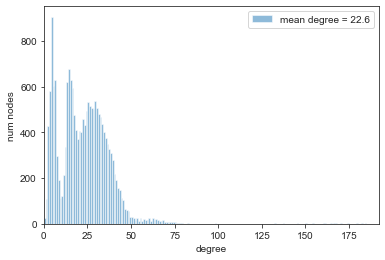

In [8]:
plot_degree_distn(graph, max_degree=max_G)

#### 6) Create node groups of 10 year age bucket to track the results

In [9]:
node_groups=create_node_groups(graph)

### Interventions

With the interventions module, we can create an intervention with just a time step and a custom network referring to that intervention, as well as remove/edit them from the list. The method get_checkpoints() will allow us to get the dictionary to be fed to the SEIRS+ model

In [14]:
interventions = Interventions()

In [15]:
# interventions.add(15, Q)
# interventions.add(45, graph)
# interventions.add("dummy", Q)

In [16]:
interventions.get_checkpoints()

{'t': [], 'G': []}

In [17]:
# interventions.remove('dummy')

In [18]:
interventions.get_checkpoints()

{'t': [], 'G': []}

In [19]:
transmission_rate = 1.28
progression_rate = 1/5.1
recovery_rate = 0.056 # Approx 1/18 -> Recovery occurs after 18 days
hosp_rate = 1/11.4 #1/6.3 # From Tucker Model
crit_rate = 0.3 # From camp_params

prob_global_contact = 1
prob_detected_global_contact = 1



prob_hosp_to_critical = list(sample_pop["death_rate"]/sample_pop["prob_hospitalisation"])
prob_asymptomatic = list(1 - sample_pop["prob_symptomatic"])
prob_symp_to_hosp = list(sample_pop["prob_hospitalisation"])

init_symp_cases = 1
init_asymp_cases = 0

In [20]:
#assumption
iso_weight=household_weight

In [52]:
# checkpoints = interventions.get_checkpoints()

ref_model = SymptomaticSEIRSNetworkModel(G=graph, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, 
                                         lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, p=prob_global_contact, a=prob_asymptomatic, f=prob_hosp_to_critical, 
                                         h=prob_symp_to_hosp, q=prob_detected_global_contact, initI_S=init_symp_cases, initI_A=init_asymp_cases, store_Xseries=True,
                                        node_groups=node_groups)

fig_name = f"SymptomaticModel_IsoWeight={iso_weight}_NeighWeight={neighbor_weight}_FoodWeight={food_weight}_ + \
TransRate={transmission_rate}_RecRate={recovery_rate}_ProgRate={progression_rate}_HospRate={hosp_rate}_initI_S={init_symp_cases}_initI_A={init_asymp_cases}"

# ref_model.run(T=10, verbose=True)#, checkpoints=checkpoints)

In [53]:
%%time
node_states, simulation_results = run_simulation(ref_model, 20, print_info=False, store_every=1)

  5%|▌         | 1/20 [00:00<00:01,  9.56it/s]

Running simulation for 20 steps...



100%|██████████| 20/20 [01:19<00:00,  3.99s/it]

CPU times: user 1min, sys: 19.2 s, total: 1min 19s
Wall time: 1min 19s


In [54]:
def find_whole_time(tseries, T):
    idt=[]
    for t in range(0, T + 1):
        idt.append(np.abs(tseries - t).argmin())
    return idt

def run_simulation_test(model, t, print_info=False):
    node_states = dict()
    simulation_results = defaultdict(list)
    
    print(f"Running simulation for {t} steps...\n")
    model.run(T=t, verbose=print_info)
    # Store the quantities of the time step closest to the integer
    time_stamps=model.tseries
    idt=find_whole_time(time_stamps,t)
    # Store the quantities of each integer time steps 
    simulation_results["Symptomatic"]=model.numS[idt]
    simulation_results["Exposed"]=model.numE[idt]
    simulation_results["Infected_Presymptomatic"]=model.numI_pre[idt]
    simulation_results["Infected_Symptomatic"]=model.numI_S[idt]
    simulation_results["Infected_Asymptomatic"]=model.numI_A[idt]
    simulation_results["Hospitalized"]=model.numH[idt]
    simulation_results["Recovered"]=model.numR[idt]
    simulation_results["Fatalities"]=model.numF[idt]
    simulation_results["Detected_Presymptomatic"]=model.numD_pre[idt]
    simulation_results["Detected_Symptomatic"]=model.numD_S[idt]
    simulation_results["Detected_Asymptomatic"]=model.numD_A[idt]

    return simulation_results

In [55]:
# checkpoints = interventions.get_checkpoints()

ref_model = SymptomaticSEIRSNetworkModel(G=graph, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, 
                                         lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, p=prob_global_contact, a=prob_asymptomatic, f=prob_hosp_to_critical, 
                                         h=prob_symp_to_hosp, q=prob_detected_global_contact, initI_S=init_symp_cases, initI_A=init_asymp_cases, store_Xseries=True,
                                        node_groups=node_groups)

fig_name = f"SymptomaticModel_IsoWeight={iso_weight}_NeighWeight={neighbor_weight}_FoodWeight={food_weight}_ + \
TransRate={transmission_rate}_RecRate={recovery_rate}_ProgRate={progression_rate}_HospRate={hosp_rate}_initI_S={init_symp_cases}_initI_A={init_asymp_cases}"

# ref_model.run(T=10, verbose=True)#, checkpoints=checkpoints)

In [57]:
%%time 
simulation_results=run_simulation_test(ref_model, 20, print_info=False)

Running simulation for 20 steps...

CPU times: user 14.8 s, sys: 2.42 s, total: 17.3 s
Wall time: 17.3 s


In [37]:
ref_model.tseries

array([ 0.        ,  0.83651323,  1.66263899, ..., 19.99928385,
       19.99977927, 20.00117589])

In [23]:
simulation_results

defaultdict(list,
            {'Symptomatic': [18697.0,
              18696.0,
              18695.0,
              18692.0,
              18686.0,
              18681.0,
              18673.0,
              18658.0,
              18631.0,
              18595.0,
              18529.0,
              18432.0,
              18291.0,
              18080.0,
              17765.0,
              17331.0,
              16651.0,
              15740.0,
              14528.0,
              12994.0],
             'Exposed': [2.0,
              3.0,
              4.0,
              5.0,
              9.0,
              13.0,
              15.0,
              29.0,
              41.0,
              65.0,
              112.0,
              176.0,
              269.0,
              415.0,
              629.0,
              897.0,
              1343.0,
              1942.0,
              2653.0,
              3594.0],
             'Infected_Presymptomatic': [0.0,
              0.0,
              0.0,
 

In [27]:
ref_model.nodeGroupData['age0-10']['numS']

array([3941., 3940., 3939., ..., 2744., 2744., 2744.])

In [25]:
len(node_states[1][0])

18700

In [111]:
simulation_results

defaultdict(list,
            {'Symptomatic': [8096.0,
              8095.0,
              8091.0,
              8085.0,
              8081.0,
              8069.0,
              8060.0,
              8028.0,
              7989.0,
              7929.0,
              7872.0,
              7754.0,
              7583.0,
              7355.0,
              7034.0,
              6586.0,
              5956.0,
              5195.0,
              4285.0,
              3269.0],
             'Exposed': [3.0,
              4.0,
              6.0,
              11.0,
              15.0,
              24.0,
              26.0,
              52.0,
              81.0,
              118.0,
              154.0,
              225.0,
              340.0,
              476.0,
              686.0,
              979.0,
              1370.0,
              1812.0,
              2315.0,
              2830.0],
             'Infected_Presymptomatic': [0.0,
              0.0,
              2.0,
              3.0,

In [ ]:
fig, ax = ref_model.figure_basic()#vlines=interventions.get_checkpoints()['t'])
fig.savefig(f"plots/{fig_name}_figBasic.png")

In [ ]:
fig, ax = ref_model.figure_infections()#vlines=interventions.get_checkpoints()['t'])
fig.savefig(f"plots/{fig_name}_figInfections.png")